In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.metrics import classification_report
from glob import glob

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import torchvision.models as models

from PIL import Image
import io
import pathlib

from tqdm import tqdm

In [3]:
image_information = pd.read_csv("drive/My Drive/Colab Notebooks/archive-2/HAM10000_metadata.csv")           

In [5]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

image_information["cell_type"] = image_information["dx"].map(lesion_type_dict.get)

image_information["cell_type_idx"] = pd.Categorical(image_information["cell_type"]).codes




In [6]:
# filter out id's that have only one image
new_data = image_information.groupby("lesion_id").count()
new_data = new_data[new_data["image_id"] == 1]
new_data.reset_index(inplace=True)
new_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1


In [7]:
def get_duplicates(x):
  unique_list = list(new_data["lesion_id"])
  if x in unique_list:
    return "unduplicated"
  else:
    return "duplicated"

image_information["duplicates"] = image_information["lesion_id"]
image_information["duplicates"] = image_information["duplicates"].apply(get_duplicates)
image_information.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2,duplicated


In [8]:
new_data = image_information[image_information["duplicates"] == "unduplicated"]
new_data.shape

(5514, 10)

In [9]:
new_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx,duplicates
10,HAM_0001396,ISIC_0025276,bkl,histo,55.0,female,trunk,Benign keratosis-like lesions,2,unduplicated
15,HAM_0007207,ISIC_0031326,bkl,histo,65.0,male,back,Benign keratosis-like lesions,2,unduplicated
20,HAM_0006071,ISIC_0032343,bkl,histo,70.0,female,face,Benign keratosis-like lesions,2,unduplicated
33,HAM_0005612,ISIC_0024981,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2,unduplicated
34,HAM_0005388,ISIC_0027815,bkl,histo,80.0,male,chest,Benign keratosis-like lesions,2,unduplicated


In [10]:
dx = new_data["dx"].value_counts()
dx

nv       4415
bkl       440
mel       230
bcc       175
akiec     151
vasc       64
df         39
Name: dx, dtype: int64

Text(0, 0.5, 'Frequency')

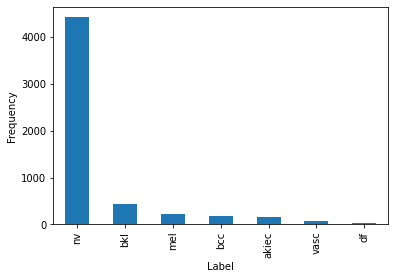

In [11]:
dx.plot.bar()
plt.xlabel('Label')
plt.ylabel('Frequency')

In [12]:
y = new_data["cell_type_idx"]
X_train, X_test, y_train, y_test = train_test_split(y,y, test_size = 0.25, stratify = y)

image_train_info = new_data.loc[y_train.index].reset_index(drop=True)
image_test_info = new_data.loc[y_test.index].reset_index(drop=True)

In [13]:
y.value_counts()

4    4415
2     440
6     230
1     175
0     151
5      64
3      39
Name: cell_type_idx, dtype: int64

## Move Images to one folder

In [ ]:
import os
import shutil

reorg_dir = "drive/My Drive/Colab Notebooks/archive-2/HAM10000_images_part_1"
target_dir = "drive/My Drive/Colab Notebooks/archive-2/HAM10000_images_part_2"

def moveTree(sourceRoot, destRoot):
    if not os.path.exists(destRoot):
        return False
    ok = True
    for path, dirs, files in os.walk(sourceRoot):
        relPath = os.path.relpath(path, sourceRoot)
        destPath = os.path.join(destRoot, relPath)
        if not os.path.exists(destPath):
            os.makedirs(destPath)
        for file in files:
            destFile = os.path.join(destPath, file)
            if os.path.isfile(destFile):
                print ("Skipping existing file: " + os.path.join(relPath, file))
                ok = False
                continue
            srcFile = os.path.join(path, file)
            #print "rename", srcFile, destFile
            os.rename(srcFile, destFile)
    for path, dirs, files in os.walk(sourceRoot, False):
        if len(files) == 0 and len(dirs) == 0:
            os.rmdir(path)
    return ok

In [ ]:
moveTree(reorg_dir, target_dir)

True

# Train


In [15]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [16]:
class HAM10000(Dataset):
  def __init__(self, df, img_dir, transform=None):
    self.df = df
    self.transform = transform
    self.img_dir = img_dir

    self.img_names = df["image_id"] + ".jpg"


  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    X = Image.open(self.img_dir + "/" + self.img_names[index])
    y = torch.tensor(int(self.df["cell_type_idx"][index]))

    if self.transform:
      X = self.transform(X)
    
    return X, y

  def __visualizeitem__(self, index):
        img = Image.open(self.img_dir + "/" + self.img_names[index])
        
        label = self.df["cell_type"][index]
        return img, label

In [17]:

dataset_train = HAM10000(df=image_train_info,
                              img_dir="drive/My Drive/Colab Notebooks/archive-2/HAM10000_images", transform=transform_train)
dataset_test = HAM10000(df=image_test_info,
                              img_dir="drive/My Drive/Colab Notebooks/archive-2/HAM10000_images", transform=transform_test)

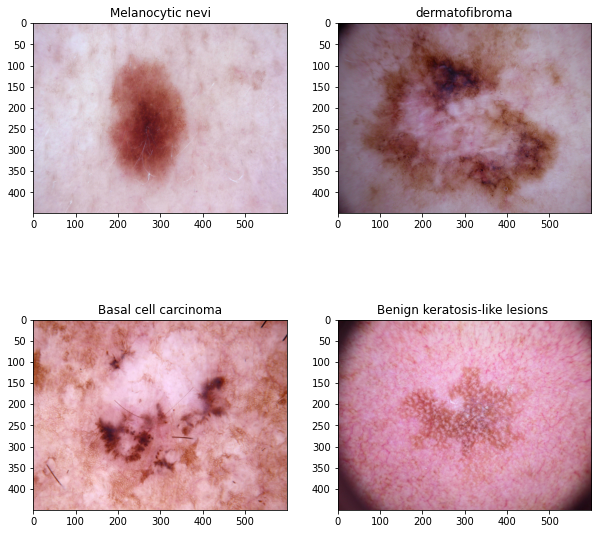

In [62]:
#Visualize random items from the training set (pretransformation)
img1, label1 = dataset_train.__visualizeitem__(10)
img2, label2 = dataset_train.__visualizeitem__(1956)
img3, label3 = dataset_train.__visualizeitem__(910)
img4, label4 = dataset_train.__visualizeitem__(3548)

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.imshow(img1)
ax1.title.set_text(label1)

ax2.imshow(img2)
ax2.title.set_text(label2)

ax3.imshow(img3)
ax3.title.set_text(label3)

ax4.imshow(img4)
ax4.title.set_text(label4)


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [20]:
from tqdm import tqdm

def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      with tqdm(testloader) as testloader:
        for images, labels in testloader:
          images, labels = images.to(device), labels.to(device)
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
    return correct / total

# OPTUNA Hyperparameter Tuning

In [28]:
!pip install optuna

     |████████████████████████████████| 286kB 20.4MB/s 
     |████████████████████████████████| 163kB 57.8MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 481kB 56.6MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 112kB 59.2MB/s 
     |████████████████████████████████| 133kB 60.3MB/s 
  Created wheel for Mako: filename=Mako-1.1.4-py2.py3-none-any.whl size=75675 sha256=9bbd99d9ae3eefe82a3b3cc244a6e1d6c26c5b3f7e2848abf8d8156189a8e027
  Stored in directory: /root/.cache/pip/wheels/ad/10/d3/aeb26e20d19045e2a68e5d3cbb57432e11b5d9c92c99f98d47
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=62c1b6745bf21d02759ddd4b4e79ad2908e48118fe84beb84918039ad8812873
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 s

In [33]:
def objective(trial):

  #generating the model
  net = models.densenet121(pretrained=True)
  num_ftrs = net.classifier.in_features
  net.classifier = nn.Linear(num_ftrs, 7)
  net.to(device)

  #defining the optimizer
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
  optimizer = getattr(optim, optimizer_name)(net.parameters(), lr=lr)

  weights = [1/151, 1/175, 1/440, 1/39, 1/4415, 1/64, 1/230]
  class_weights = torch.FloatTensor(weights).to(device)
  criterion = nn.CrossEntropyLoss(weight=class_weights)

  #train and test loaders
  batchsize = trial.suggest_int("batchsize", 8, 32)
  train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
  test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=False)

  #training
  net.train()
  for epoch in range(1):
    print_every = 10
    running_loss = 0.0
    best_accuracy = 0.0
    with tqdm(train_loader) as train_loader:
      for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        if (i % print_every) == (print_every-1):
          print("[%d, %5d] Loss: %.3f" % (epoch + 1, i+1, running_loss/print_every))
          running_loss = 0.0

    #getting accuracy on the test set     
    accuracy = compute_accuracy(net, test_loader)

    trial.report(accuracy, epoch)

  return accuracy



In [34]:
import optuna

if __name__ == "__main__":
  sampler = optuna.samplers.TPESampler()
  study = optuna.create_study(direction= "maximize", sampler=sampler)
  study.optimize(objective, n_trials = 15)

  pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
  complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

  print("Study statistics: ")
  print("  Number of finished trials: ", len(study.trials))
  print("  Number of pruned trials: ", len(pruned_trials))
  print("  Number of complete trials: ", len(complete_trials))

  print("Best trial:")
  trial = study.best_trial

  print("  Value: ", trial.value)

  print("  Params: ")
  for key, value in trial.params.items():
      print("    {}: {}".format(key, value))



[I 2021-01-17 06:15:24,598] A new study created in memory with name: no-name-5fb74008-bf7c-425a-a509-d101e8c9c4d5
  4%|▎         | 10/276 [00:04<02:05,  2.13it/s]

[1,    10] Loss: 1.926


  7%|▋         | 20/276 [00:09<01:58,  2.16it/s]

[1,    20] Loss: 1.915


 11%|█         | 30/276 [00:14<01:56,  2.11it/s]

[1,    30] Loss: 1.887


 14%|█▍        | 40/276 [00:18<01:50,  2.14it/s]

[1,    40] Loss: 1.646


 18%|█▊        | 50/276 [00:23<01:43,  2.19it/s]

[1,    50] Loss: 1.775


 22%|██▏       | 60/276 [00:28<01:42,  2.12it/s]

[1,    60] Loss: 1.658


 25%|██▌       | 70/276 [00:32<01:36,  2.14it/s]

[1,    70] Loss: 1.524


 29%|██▉       | 80/276 [00:37<01:33,  2.10it/s]

[1,    80] Loss: 1.606


 33%|███▎      | 90/276 [00:42<01:26,  2.16it/s]

[1,    90] Loss: 1.562


 36%|███▌      | 100/276 [00:46<01:23,  2.11it/s]

[1,   100] Loss: 1.509


 40%|███▉      | 110/276 [00:51<01:19,  2.08it/s]

[1,   110] Loss: 1.625


 43%|████▎     | 120/276 [00:56<01:13,  2.12it/s]

[1,   120] Loss: 1.483


 47%|████▋     | 130/276 [01:01<01:08,  2.13it/s]

[1,   130] Loss: 1.443


 51%|█████     | 140/276 [01:05<01:03,  2.14it/s]

[1,   140] Loss: 1.303


 54%|█████▍    | 150/276 [01:10<00:58,  2.14it/s]

[1,   150] Loss: 1.273


 58%|█████▊    | 160/276 [01:15<00:53,  2.17it/s]

[1,   160] Loss: 1.211


 62%|██████▏   | 170/276 [01:19<00:49,  2.15it/s]

[1,   170] Loss: 1.392


 65%|██████▌   | 180/276 [01:24<00:44,  2.14it/s]

[1,   180] Loss: 1.240


 69%|██████▉   | 190/276 [01:29<00:40,  2.12it/s]

[1,   190] Loss: 1.162


 72%|███████▏  | 200/276 [01:33<00:35,  2.16it/s]

[1,   200] Loss: 1.170


 76%|███████▌  | 210/276 [01:38<00:31,  2.12it/s]

[1,   210] Loss: 1.256


 80%|███████▉  | 220/276 [01:43<00:25,  2.16it/s]

[1,   220] Loss: 1.288


 83%|████████▎ | 230/276 [01:47<00:21,  2.17it/s]

[1,   230] Loss: 1.279


 87%|████████▋ | 240/276 [01:52<00:16,  2.14it/s]

[1,   240] Loss: 1.203


 91%|█████████ | 250/276 [01:57<00:12,  2.12it/s]

[1,   250] Loss: 1.046


 94%|█████████▍| 260/276 [02:02<00:07,  2.11it/s]

[1,   260] Loss: 1.085


 98%|█████████▊| 270/276 [02:06<00:02,  2.15it/s]

[1,   270] Loss: 1.256


100%|██████████| 44/44 [00:20<00:00,  2.11it/s]
[I 2021-01-17 06:17:55,073] Trial 0 finished with value: 0.7418419144307469 and parameters: {'optimizer': 'Adam', 'lr': 4.7584462500202006e-05, 'batchsize': 15}. Best is trial 0 with value: 0.7418419144307469.
  2%|▏         | 10/460 [00:02<02:05,  3.58it/s]

[1,    10] Loss: 1.837


  4%|▍         | 20/460 [00:05<02:00,  3.64it/s]

[1,    20] Loss: 2.212


  7%|▋         | 30/460 [00:08<01:58,  3.62it/s]

[1,    30] Loss: 1.756


  9%|▊         | 40/460 [00:11<01:55,  3.62it/s]

[1,    40] Loss: 1.978


 11%|█         | 50/460 [00:13<02:00,  3.40it/s]

[1,    50] Loss: 1.758


 13%|█▎        | 60/460 [00:16<01:52,  3.54it/s]

[1,    60] Loss: 2.292


 15%|█▌        | 70/460 [00:19<01:48,  3.58it/s]

[1,    70] Loss: 1.438


 17%|█▋        | 80/460 [00:22<01:47,  3.55it/s]

[1,    80] Loss: 1.499


 20%|█▉        | 90/460 [00:25<01:42,  3.62it/s]

[1,    90] Loss: 1.327


 22%|██▏       | 100/460 [00:28<01:41,  3.55it/s]

[1,   100] Loss: 1.807


 24%|██▍       | 110/460 [00:30<01:40,  3.48it/s]

[1,   110] Loss: 1.308


 26%|██▌       | 120/460 [00:33<01:33,  3.62it/s]

[1,   120] Loss: 1.399


 28%|██▊       | 130/460 [00:36<01:32,  3.58it/s]

[1,   130] Loss: 1.739


 30%|███       | 140/460 [00:39<01:32,  3.48it/s]

[1,   140] Loss: 1.520


 33%|███▎      | 150/460 [00:42<01:28,  3.50it/s]

[1,   150] Loss: 1.684


 35%|███▍      | 160/460 [00:45<01:23,  3.61it/s]

[1,   160] Loss: 1.172


 37%|███▋      | 170/460 [00:47<01:20,  3.60it/s]

[1,   170] Loss: 1.134


 39%|███▉      | 180/460 [00:50<01:19,  3.54it/s]

[1,   180] Loss: 1.182


 41%|████▏     | 190/460 [00:53<01:14,  3.64it/s]

[1,   190] Loss: 1.221


 43%|████▎     | 200/460 [00:56<01:11,  3.62it/s]

[1,   200] Loss: 1.598


 46%|████▌     | 210/460 [00:59<01:11,  3.50it/s]

[1,   210] Loss: 1.384


 48%|████▊     | 220/460 [01:01<01:08,  3.49it/s]

[1,   220] Loss: 1.552


 50%|█████     | 230/460 [01:04<01:05,  3.51it/s]

[1,   230] Loss: 0.923


 52%|█████▏    | 240/460 [01:07<01:02,  3.52it/s]

[1,   240] Loss: 1.207


 54%|█████▍    | 250/460 [01:10<00:58,  3.60it/s]

[1,   250] Loss: 1.357


 57%|█████▋    | 260/460 [01:13<00:56,  3.53it/s]

[1,   260] Loss: 1.363


 59%|█████▊    | 270/460 [01:15<00:54,  3.49it/s]

[1,   270] Loss: 1.334


 61%|██████    | 280/460 [01:18<00:50,  3.59it/s]

[1,   280] Loss: 1.128


 63%|██████▎   | 290/460 [01:21<00:48,  3.50it/s]

[1,   290] Loss: 1.328


 65%|██████▌   | 300/460 [01:24<00:43,  3.64it/s]

[1,   300] Loss: 1.405


 67%|██████▋   | 310/460 [01:27<00:42,  3.53it/s]

[1,   310] Loss: 1.154


 70%|██████▉   | 320/460 [01:29<00:39,  3.55it/s]

[1,   320] Loss: 1.432


 72%|███████▏  | 330/460 [01:32<00:36,  3.59it/s]

[1,   330] Loss: 1.462


 74%|███████▍  | 340/460 [01:35<00:33,  3.60it/s]

[1,   340] Loss: 0.846


 76%|███████▌  | 350/460 [01:38<00:31,  3.49it/s]

[1,   350] Loss: 1.260


 78%|███████▊  | 360/460 [01:41<00:27,  3.64it/s]

[1,   360] Loss: 1.632


 80%|████████  | 370/460 [01:43<00:25,  3.58it/s]

[1,   370] Loss: 1.574


 83%|████████▎ | 380/460 [01:46<00:22,  3.50it/s]

[1,   380] Loss: 1.170


 85%|████████▍ | 390/460 [01:49<00:20,  3.48it/s]

[1,   390] Loss: 0.974


 87%|████████▋ | 400/460 [01:52<00:16,  3.65it/s]

[1,   400] Loss: 1.213


 89%|████████▉ | 410/460 [01:55<00:13,  3.63it/s]

[1,   410] Loss: 1.055


 91%|█████████▏| 420/460 [01:58<00:11,  3.57it/s]

[1,   420] Loss: 1.632


 93%|█████████▎| 430/460 [02:00<00:08,  3.66it/s]

[1,   430] Loss: 1.097


 96%|█████████▌| 440/460 [02:03<00:05,  3.69it/s]

[1,   440] Loss: 1.083


 98%|█████████▊| 450/460 [02:06<00:02,  3.49it/s]

[1,   450] Loss: 1.057


  0%|          | 0/44 [00:00<?, ?it/s]

[1,   460] Loss: 1.036


100%|██████████| 44/44 [00:20<00:00,  2.13it/s]
[I 2021-01-17 06:20:24,972] Trial 1 finished with value: 0.12980420594633793 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0001508171321791898, 'batchsize': 9}. Best is trial 0 with value: 0.7418419144307469.
  3%|▎         | 10/345 [00:03<01:59,  2.81it/s]

[1,    10] Loss: 3.516


  6%|▌         | 20/345 [00:07<01:56,  2.80it/s]

[1,    20] Loss: 2.894


  9%|▊         | 30/345 [00:10<01:51,  2.83it/s]

[1,    30] Loss: 2.639


 12%|█▏        | 40/345 [00:14<01:48,  2.80it/s]

[1,    40] Loss: 2.036


 14%|█▍        | 50/345 [00:17<01:43,  2.84it/s]

[1,    50] Loss: 1.841


 17%|█▋        | 60/345 [00:21<01:41,  2.80it/s]

[1,    60] Loss: 1.804


 20%|██        | 70/345 [00:24<01:37,  2.83it/s]

[1,    70] Loss: 2.161


 23%|██▎       | 80/345 [00:28<01:35,  2.78it/s]

[1,    80] Loss: 2.640


 26%|██▌       | 90/345 [00:32<01:31,  2.77it/s]

[1,    90] Loss: 2.051


 29%|██▉       | 100/345 [00:35<01:25,  2.86it/s]

[1,   100] Loss: 2.445


 32%|███▏      | 110/345 [00:39<01:22,  2.83it/s]

[1,   110] Loss: 2.406


 35%|███▍      | 120/345 [00:42<01:19,  2.85it/s]

[1,   120] Loss: 2.582


 38%|███▊      | 130/345 [00:46<01:15,  2.85it/s]

[1,   130] Loss: 2.111


 41%|████      | 140/345 [00:49<01:11,  2.85it/s]

[1,   140] Loss: 1.895


 43%|████▎     | 150/345 [00:53<01:08,  2.83it/s]

[1,   150] Loss: 2.214


 46%|████▋     | 160/345 [00:56<01:06,  2.77it/s]

[1,   160] Loss: 2.247


 49%|████▉     | 170/345 [01:00<01:02,  2.80it/s]

[1,   170] Loss: 1.682


 52%|█████▏    | 180/345 [01:03<00:58,  2.82it/s]

[1,   180] Loss: 1.627


 55%|█████▌    | 190/345 [01:07<00:55,  2.81it/s]

[1,   190] Loss: 1.579


 58%|█████▊    | 200/345 [01:10<00:50,  2.85it/s]

[1,   200] Loss: 1.433


 61%|██████    | 210/345 [01:14<00:48,  2.79it/s]

[1,   210] Loss: 1.881


 64%|██████▍   | 220/345 [01:18<00:43,  2.86it/s]

[1,   220] Loss: 1.380


 67%|██████▋   | 230/345 [01:21<00:40,  2.84it/s]

[1,   230] Loss: 1.684


 70%|██████▉   | 240/345 [01:25<00:37,  2.83it/s]

[1,   240] Loss: 1.721


 72%|███████▏  | 250/345 [01:28<00:32,  2.88it/s]

[1,   250] Loss: 1.566


 75%|███████▌  | 260/345 [01:32<00:30,  2.78it/s]

[1,   260] Loss: 2.051


 78%|███████▊  | 270/345 [01:35<00:26,  2.79it/s]

[1,   270] Loss: 1.581


 81%|████████  | 280/345 [01:39<00:23,  2.76it/s]

[1,   280] Loss: 1.509


 84%|████████▍ | 290/345 [01:42<00:19,  2.83it/s]

[1,   290] Loss: 2.295


 87%|████████▋ | 300/345 [01:46<00:15,  2.86it/s]

[1,   300] Loss: 1.928


 90%|████████▉ | 310/345 [01:49<00:12,  2.83it/s]

[1,   310] Loss: 1.487


 93%|█████████▎| 320/345 [01:53<00:08,  2.85it/s]

[1,   320] Loss: 1.637


 96%|█████████▌| 330/345 [01:57<00:05,  2.80it/s]

[1,   330] Loss: 2.243


 99%|█████████▊| 340/345 [02:00<00:01,  2.79it/s]

[1,   340] Loss: 1.983


100%|██████████| 44/44 [00:20<00:00,  2.14it/s]
[I 2021-01-17 06:22:48,108] Trial 2 finished with value: 0.4807831762146483 and parameters: {'optimizer': 'RMSprop', 'lr': 0.0015011474339003757, 'batchsize': 12}. Best is trial 0 with value: 0.7418419144307469.
  5%|▍         | 10/218 [00:05<02:01,  1.71it/s]

[1,    10] Loss: 2.183


  9%|▉         | 20/218 [00:11<01:57,  1.69it/s]

[1,    20] Loss: 1.958


 14%|█▍        | 30/218 [00:17<01:50,  1.71it/s]

[1,    30] Loss: 2.184


 18%|█▊        | 40/218 [00:23<01:43,  1.73it/s]

[1,    40] Loss: 1.557


 23%|██▎       | 50/218 [00:29<01:40,  1.67it/s]

[1,    50] Loss: 1.662


 28%|██▊       | 60/218 [00:35<01:32,  1.70it/s]

[1,    60] Loss: 1.737


 32%|███▏      | 70/218 [00:41<01:25,  1.72it/s]

[1,    70] Loss: 1.965


 37%|███▋      | 80/218 [00:46<01:21,  1.70it/s]

[1,    80] Loss: 1.917


 41%|████▏     | 90/218 [00:52<01:14,  1.71it/s]

[1,    90] Loss: 1.542


 46%|████▌     | 100/218 [00:58<01:08,  1.72it/s]

[1,   100] Loss: 1.653


 50%|█████     | 110/218 [01:04<01:02,  1.73it/s]

[1,   110] Loss: 2.077


 55%|█████▌    | 120/218 [01:10<00:58,  1.69it/s]

[1,   120] Loss: 2.137


 60%|█████▉    | 130/218 [01:16<00:51,  1.70it/s]

[1,   130] Loss: 1.928


 64%|██████▍   | 140/218 [01:22<00:45,  1.70it/s]

[1,   140] Loss: 1.959


 69%|██████▉   | 150/218 [01:28<00:39,  1.71it/s]

[1,   150] Loss: 1.698


 73%|███████▎  | 160/218 [01:33<00:34,  1.70it/s]

[1,   160] Loss: 1.671


 78%|███████▊  | 170/218 [01:39<00:28,  1.66it/s]

[1,   170] Loss: 2.230


 83%|████████▎ | 180/218 [01:45<00:22,  1.71it/s]

[1,   180] Loss: 1.714


 87%|████████▋ | 190/218 [01:51<00:16,  1.70it/s]

[1,   190] Loss: 1.777


 92%|█████████▏| 200/218 [01:57<00:10,  1.72it/s]

[1,   200] Loss: 1.877


 96%|█████████▋| 210/218 [02:03<00:04,  1.72it/s]

[1,   210] Loss: 1.557


100%|██████████| 44/44 [00:20<00:00,  2.15it/s]
[I 2021-01-17 06:25:16,673] Trial 3 finished with value: 0.6142131979695431 and parameters: {'optimizer': 'Adam', 'lr': 0.0009713919842341056, 'batchsize': 19}. Best is trial 0 with value: 0.7418419144307469.
  3%|▎         | 10/296 [00:04<01:53,  2.52it/s]

[1,    10] Loss: 2.065


  7%|▋         | 20/296 [00:07<01:48,  2.53it/s]

[1,    20] Loss: 2.093


 10%|█         | 30/296 [00:11<01:45,  2.52it/s]

[1,    30] Loss: 1.909


 14%|█▎        | 40/296 [00:15<01:42,  2.50it/s]

[1,    40] Loss: 1.986


 17%|█▋        | 50/296 [00:19<01:37,  2.52it/s]

[1,    50] Loss: 2.116


 20%|██        | 60/296 [00:23<01:35,  2.47it/s]

[1,    60] Loss: 1.959


 24%|██▎       | 70/296 [00:27<01:31,  2.47it/s]

[1,    70] Loss: 1.972


 27%|██▋       | 80/296 [00:32<01:26,  2.48it/s]

[1,    80] Loss: 1.860


 30%|███       | 90/296 [00:36<01:21,  2.53it/s]

[1,    90] Loss: 1.940


 34%|███▍      | 100/296 [00:39<01:18,  2.51it/s]

[1,   100] Loss: 1.950


 37%|███▋      | 110/296 [00:44<01:16,  2.42it/s]

[1,   110] Loss: 1.945


 41%|████      | 120/296 [00:47<01:09,  2.52it/s]

[1,   120] Loss: 1.938


 44%|████▍     | 130/296 [00:51<01:05,  2.53it/s]

[1,   130] Loss: 1.905


 47%|████▋     | 140/296 [00:55<01:01,  2.52it/s]

[1,   140] Loss: 1.853


 51%|█████     | 150/296 [00:59<00:58,  2.49it/s]

[1,   150] Loss: 1.826


 54%|█████▍    | 160/296 [01:03<00:54,  2.49it/s]

[1,   160] Loss: 1.911


 57%|█████▋    | 170/296 [01:07<00:49,  2.52it/s]

[1,   170] Loss: 1.840


 61%|██████    | 180/296 [01:11<00:46,  2.51it/s]

[1,   180] Loss: 1.755


 64%|██████▍   | 190/296 [01:16<00:44,  2.38it/s]

[1,   190] Loss: 1.720


 68%|██████▊   | 200/296 [01:20<00:38,  2.48it/s]

[1,   200] Loss: 1.936


 71%|███████   | 210/296 [01:24<00:35,  2.40it/s]

[1,   210] Loss: 1.875


 74%|███████▍  | 220/296 [01:28<00:30,  2.53it/s]

[1,   220] Loss: 1.897


 78%|███████▊  | 230/296 [01:32<00:26,  2.49it/s]

[1,   230] Loss: 1.808


 81%|████████  | 240/296 [01:36<00:22,  2.49it/s]

[1,   240] Loss: 1.883


 84%|████████▍ | 250/296 [01:40<00:18,  2.44it/s]

[1,   250] Loss: 1.849


 88%|████████▊ | 260/296 [01:44<00:14,  2.48it/s]

[1,   260] Loss: 1.753


 91%|█████████ | 270/296 [01:48<00:10,  2.46it/s]

[1,   270] Loss: 1.931


 95%|█████████▍| 280/296 [01:52<00:06,  2.52it/s]

[1,   280] Loss: 1.809


 98%|█████████▊| 290/296 [01:56<00:02,  2.47it/s]

[1,   290] Loss: 1.703


100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
[I 2021-01-17 06:27:36,282] Trial 4 finished with value: 0.751269035532995 and parameters: {'optimizer': 'SGD', 'lr': 0.00020401961501514417, 'batchsize': 14}. Best is trial 4 with value: 0.751269035532995.
  2%|▏         | 10/414 [00:03<02:05,  3.21it/s]

[1,    10] Loss: 3.198


  5%|▍         | 20/414 [00:06<02:02,  3.21it/s]

[1,    20] Loss: 2.098


  7%|▋         | 30/414 [00:09<02:00,  3.19it/s]

[1,    30] Loss: 2.075


 10%|▉         | 40/414 [00:12<01:56,  3.22it/s]

[1,    40] Loss: 1.599


 12%|█▏        | 50/414 [00:15<01:59,  3.06it/s]

[1,    50] Loss: 1.885


 14%|█▍        | 60/414 [00:18<01:54,  3.09it/s]

[1,    60] Loss: 2.355


 17%|█▋        | 70/414 [00:22<01:45,  3.25it/s]

[1,    70] Loss: 2.263


 19%|█▉        | 80/414 [00:25<01:42,  3.24it/s]

[1,    80] Loss: 3.582


 22%|██▏       | 90/414 [00:28<01:44,  3.11it/s]

[1,    90] Loss: 2.157


 24%|██▍       | 100/414 [00:31<01:37,  3.23it/s]

[1,   100] Loss: 2.192


 27%|██▋       | 110/414 [00:34<01:33,  3.25it/s]

[1,   110] Loss: 2.244


 29%|██▉       | 120/414 [00:37<01:30,  3.26it/s]

[1,   120] Loss: 1.640


 31%|███▏      | 130/414 [00:40<01:29,  3.17it/s]

[1,   130] Loss: 1.660


 34%|███▍      | 140/414 [00:43<01:25,  3.22it/s]

[1,   140] Loss: 1.451


 36%|███▌      | 150/414 [00:47<01:23,  3.17it/s]

[1,   150] Loss: 2.028


 39%|███▊      | 160/414 [00:50<01:20,  3.17it/s]

[1,   160] Loss: 1.556


 41%|████      | 170/414 [00:53<01:15,  3.24it/s]

[1,   170] Loss: 2.110


 43%|████▎     | 180/414 [00:56<01:14,  3.16it/s]

[1,   180] Loss: 1.782


 46%|████▌     | 190/414 [00:59<01:09,  3.24it/s]

[1,   190] Loss: 1.820


 48%|████▊     | 200/414 [01:02<01:08,  3.14it/s]

[1,   200] Loss: 2.262


 51%|█████     | 210/414 [01:06<01:04,  3.19it/s]

[1,   210] Loss: 2.087


 53%|█████▎    | 220/414 [01:09<01:00,  3.23it/s]

[1,   220] Loss: 1.717


 56%|█████▌    | 230/414 [01:12<00:56,  3.24it/s]

[1,   230] Loss: 1.863


 58%|█████▊    | 240/414 [01:15<00:53,  3.22it/s]

[1,   240] Loss: 1.937


 60%|██████    | 250/414 [01:18<00:52,  3.13it/s]

[1,   250] Loss: 1.516


 63%|██████▎   | 260/414 [01:21<00:47,  3.21it/s]

[1,   260] Loss: 2.612


 65%|██████▌   | 270/414 [01:24<00:44,  3.27it/s]

[1,   270] Loss: 2.926


 68%|██████▊   | 280/414 [01:27<00:41,  3.26it/s]

[1,   280] Loss: 2.026


 70%|███████   | 290/414 [01:31<00:37,  3.27it/s]

[1,   290] Loss: 1.775


 72%|███████▏  | 300/414 [01:34<00:37,  3.06it/s]

[1,   300] Loss: 2.373


 75%|███████▍  | 310/414 [01:37<00:32,  3.20it/s]

[1,   310] Loss: 1.585


 77%|███████▋  | 320/414 [01:40<00:28,  3.28it/s]

[1,   320] Loss: 1.785


 80%|███████▉  | 330/414 [01:43<00:25,  3.26it/s]

[1,   330] Loss: 1.508


 82%|████████▏ | 340/414 [01:46<00:22,  3.28it/s]

[1,   340] Loss: 1.206


 85%|████████▍ | 350/414 [01:49<00:19,  3.24it/s]

[1,   350] Loss: 1.819


 87%|████████▋ | 360/414 [01:52<00:16,  3.20it/s]

[1,   360] Loss: 1.806


 89%|████████▉ | 370/414 [01:55<00:13,  3.21it/s]

[1,   370] Loss: 1.650


 92%|█████████▏| 380/414 [01:58<00:10,  3.25it/s]

[1,   380] Loss: 1.697


 94%|█████████▍| 390/414 [02:02<00:07,  3.10it/s]

[1,   390] Loss: 1.793


 97%|█████████▋| 400/414 [02:05<00:04,  3.20it/s]

[1,   400] Loss: 1.773


 99%|█████████▉| 410/414 [02:08<00:01,  3.21it/s]

[1,   410] Loss: 2.376


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
[I 2021-01-17 06:30:06,325] Trial 5 finished with value: 0.6055112400290066 and parameters: {'optimizer': 'Adam', 'lr': 0.0027971039436751528, 'batchsize': 10}. Best is trial 4 with value: 0.751269035532995.
  4%|▍         | 10/244 [00:05<02:02,  1.90it/s]

[1,    10] Loss: 15.439


  8%|▊         | 20/244 [00:10<01:57,  1.90it/s]

[1,    20] Loss: 3.319


 12%|█▏        | 30/244 [00:15<01:50,  1.94it/s]

[1,    30] Loss: 4.061


 16%|█▋        | 40/244 [00:20<01:45,  1.94it/s]

[1,    40] Loss: 2.308


 20%|██        | 50/244 [00:26<01:40,  1.93it/s]

[1,    50] Loss: 1.972


 25%|██▍       | 60/244 [00:31<01:36,  1.90it/s]

[1,    60] Loss: 2.433


 29%|██▊       | 70/244 [00:36<01:30,  1.91it/s]

[1,    70] Loss: 2.324


 33%|███▎      | 80/244 [00:41<01:26,  1.90it/s]

[1,    80] Loss: 2.105


 37%|███▋      | 90/244 [00:47<01:21,  1.90it/s]

[1,    90] Loss: 1.877


 41%|████      | 100/244 [00:52<01:16,  1.88it/s]

[1,   100] Loss: 2.213


 45%|████▌     | 110/244 [00:57<01:10,  1.89it/s]

[1,   110] Loss: 1.939


 49%|████▉     | 120/244 [01:03<01:04,  1.92it/s]

[1,   120] Loss: 1.833


 53%|█████▎    | 130/244 [01:08<00:59,  1.91it/s]

[1,   130] Loss: 2.033


 57%|█████▋    | 140/244 [01:13<00:55,  1.89it/s]

[1,   140] Loss: 1.996


 61%|██████▏   | 150/244 [01:18<00:49,  1.89it/s]

[1,   150] Loss: 1.784


 66%|██████▌   | 160/244 [01:24<00:43,  1.92it/s]

[1,   160] Loss: 2.042


 70%|██████▉   | 170/244 [01:29<00:39,  1.90it/s]

[1,   170] Loss: 1.849


 74%|███████▍  | 180/244 [01:34<00:33,  1.89it/s]

[1,   180] Loss: 2.767


 78%|███████▊  | 190/244 [01:39<00:28,  1.89it/s]

[1,   190] Loss: 2.176


 82%|████████▏ | 200/244 [01:45<00:23,  1.89it/s]

[1,   200] Loss: 1.974


 86%|████████▌ | 210/244 [01:50<00:17,  1.94it/s]

[1,   210] Loss: 1.938


 90%|█████████ | 220/244 [01:55<00:12,  1.93it/s]

[1,   220] Loss: 3.557


 94%|█████████▍| 230/244 [02:00<00:07,  1.90it/s]

[1,   230] Loss: 2.408


 98%|█████████▊| 240/244 [02:05<00:02,  1.92it/s]

[1,   240] Loss: 1.936


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
[I 2021-01-17 06:32:34,669] Trial 6 finished with value: 0.49746192893401014 and parameters: {'optimizer': 'RMSprop', 'lr': 0.004794875575909783, 'batchsize': 17}. Best is trial 4 with value: 0.751269035532995.
  4%|▎         | 10/276 [00:04<02:03,  2.16it/s]

[1,    10] Loss: 1.941


  7%|▋         | 20/276 [00:09<01:58,  2.16it/s]

[1,    20] Loss: 1.801


 11%|█         | 30/276 [00:13<01:53,  2.17it/s]

[1,    30] Loss: 1.769


 14%|█▍        | 40/276 [00:18<01:49,  2.16it/s]

[1,    40] Loss: 1.755


 18%|█▊        | 50/276 [00:23<01:43,  2.19it/s]

[1,    50] Loss: 1.626


 22%|██▏       | 60/276 [00:27<01:39,  2.17it/s]

[1,    60] Loss: 1.618


 25%|██▌       | 70/276 [00:32<01:34,  2.18it/s]

[1,    70] Loss: 1.537


 29%|██▉       | 80/276 [00:36<01:30,  2.17it/s]

[1,    80] Loss: 1.276


 33%|███▎      | 90/276 [00:41<01:25,  2.18it/s]

[1,    90] Loss: 1.421


 36%|███▌      | 100/276 [00:46<01:21,  2.17it/s]

[1,   100] Loss: 1.387


 40%|███▉      | 110/276 [00:50<01:16,  2.18it/s]

[1,   110] Loss: 1.253


 43%|████▎     | 120/276 [00:55<01:11,  2.18it/s]

[1,   120] Loss: 1.141


 47%|████▋     | 130/276 [01:00<01:07,  2.17it/s]

[1,   130] Loss: 1.132


 51%|█████     | 140/276 [01:04<01:02,  2.16it/s]

[1,   140] Loss: 1.199


 54%|█████▍    | 150/276 [01:09<00:57,  2.18it/s]

[1,   150] Loss: 1.261


 58%|█████▊    | 160/276 [01:13<00:53,  2.19it/s]

[1,   160] Loss: 1.007


 62%|██████▏   | 170/276 [01:18<00:48,  2.18it/s]

[1,   170] Loss: 1.172


 65%|██████▌   | 180/276 [01:23<00:44,  2.17it/s]

[1,   180] Loss: 1.293


 69%|██████▉   | 190/276 [01:27<00:39,  2.17it/s]

[1,   190] Loss: 1.042


 72%|███████▏  | 200/276 [01:32<00:35,  2.15it/s]

[1,   200] Loss: 1.184


 76%|███████▌  | 210/276 [01:37<00:30,  2.15it/s]

[1,   210] Loss: 1.256


 80%|███████▉  | 220/276 [01:41<00:25,  2.18it/s]

[1,   220] Loss: 1.097


 83%|████████▎ | 230/276 [01:46<00:21,  2.14it/s]

[1,   230] Loss: 1.098


 87%|████████▋ | 240/276 [01:51<00:17,  2.07it/s]

[1,   240] Loss: 0.960


 91%|█████████ | 250/276 [01:55<00:11,  2.18it/s]

[1,   250] Loss: 0.878


 94%|█████████▍| 260/276 [02:00<00:07,  2.14it/s]

[1,   260] Loss: 1.037


 98%|█████████▊| 270/276 [02:05<00:02,  2.14it/s]

[1,   270] Loss: 0.879


100%|██████████| 44/44 [00:20<00:00,  2.14it/s]
[I 2021-01-17 06:35:03,141] Trial 7 finished with value: 0.7737490935460478 and parameters: {'optimizer': 'Adam', 'lr': 0.00011994520740599093, 'batchsize': 15}. Best is trial 7 with value: 0.7737490935460478.
  5%|▍         | 10/218 [00:05<02:02,  1.70it/s]

[1,    10] Loss: 1.853


  9%|▉         | 20/218 [00:11<01:56,  1.69it/s]

[1,    20] Loss: 1.851


 14%|█▍        | 30/218 [00:17<01:49,  1.72it/s]

[1,    30] Loss: 1.635


 18%|█▊        | 40/218 [00:23<01:43,  1.73it/s]

[1,    40] Loss: 1.458


 23%|██▎       | 50/218 [00:29<01:38,  1.70it/s]

[1,    50] Loss: 1.481


 28%|██▊       | 60/218 [00:35<01:32,  1.71it/s]

[1,    60] Loss: 1.480


 32%|███▏      | 70/218 [00:41<01:25,  1.72it/s]

[1,    70] Loss: 1.460


 37%|███▋      | 80/218 [00:46<01:21,  1.70it/s]

[1,    80] Loss: 1.352


 41%|████▏     | 90/218 [00:52<01:14,  1.72it/s]

[1,    90] Loss: 1.171


 46%|████▌     | 100/218 [00:58<01:10,  1.67it/s]

[1,   100] Loss: 1.321


 50%|█████     | 110/218 [01:04<01:03,  1.70it/s]

[1,   110] Loss: 1.006


 55%|█████▌    | 120/218 [01:10<00:57,  1.69it/s]

[1,   120] Loss: 1.092


 60%|█████▉    | 130/218 [01:16<00:52,  1.68it/s]

[1,   130] Loss: 1.502


 64%|██████▍   | 140/218 [01:22<00:45,  1.70it/s]

[1,   140] Loss: 1.225


 69%|██████▉   | 150/218 [01:28<00:40,  1.68it/s]

[1,   150] Loss: 1.196


 73%|███████▎  | 160/218 [01:34<00:34,  1.69it/s]

[1,   160] Loss: 0.884


 78%|███████▊  | 170/218 [01:39<00:28,  1.71it/s]

[1,   170] Loss: 0.955


 83%|████████▎ | 180/218 [01:45<00:22,  1.69it/s]

[1,   180] Loss: 1.115


 87%|████████▋ | 190/218 [01:51<00:16,  1.71it/s]

[1,   190] Loss: 1.032


 92%|█████████▏| 200/218 [01:57<00:10,  1.73it/s]

[1,   200] Loss: 1.344


 96%|█████████▋| 210/218 [02:03<00:04,  1.70it/s]

[1,   210] Loss: 1.315


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
[I 2021-01-17 06:37:31,793] Trial 8 finished with value: 0.7751994198694706 and parameters: {'optimizer': 'Adam', 'lr': 0.00011188876439487678, 'batchsize': 19}. Best is trial 8 with value: 0.7751994198694706.
  3%|▎         | 10/345 [00:03<02:02,  2.72it/s]

[1,    10] Loss: 2.035


  6%|▌         | 20/345 [00:07<01:57,  2.77it/s]

[1,    20] Loss: 1.881


  9%|▊         | 30/345 [00:10<01:54,  2.75it/s]

[1,    30] Loss: 1.491


 12%|█▏        | 40/345 [00:14<01:49,  2.80it/s]

[1,    40] Loss: 1.880


 14%|█▍        | 50/345 [00:18<01:48,  2.71it/s]

[1,    50] Loss: 1.512


 17%|█▋        | 60/345 [00:21<01:42,  2.78it/s]

[1,    60] Loss: 1.501


 20%|██        | 70/345 [00:25<01:39,  2.77it/s]

[1,    70] Loss: 1.701


 23%|██▎       | 80/345 [00:29<01:36,  2.74it/s]

[1,    80] Loss: 1.763


 26%|██▌       | 90/345 [00:32<01:32,  2.74it/s]

[1,    90] Loss: 1.608


 29%|██▉       | 100/345 [00:36<01:29,  2.75it/s]

[1,   100] Loss: 1.318


 32%|███▏      | 110/345 [00:40<01:24,  2.77it/s]

[1,   110] Loss: 1.870


 35%|███▍      | 120/345 [00:43<01:21,  2.76it/s]

[1,   120] Loss: 1.356


 38%|███▊      | 130/345 [00:47<01:19,  2.71it/s]

[1,   130] Loss: 1.579


 41%|████      | 140/345 [00:51<01:14,  2.77it/s]

[1,   140] Loss: 1.570


 43%|████▎     | 150/345 [00:54<01:10,  2.75it/s]

[1,   150] Loss: 1.743


 46%|████▋     | 160/345 [00:58<01:08,  2.71it/s]

[1,   160] Loss: 2.056


 49%|████▉     | 170/345 [01:01<01:03,  2.78it/s]

[1,   170] Loss: 1.399


 52%|█████▏    | 180/345 [01:05<01:01,  2.67it/s]

[1,   180] Loss: 1.373


 55%|█████▌    | 190/345 [01:09<00:57,  2.69it/s]

[1,   190] Loss: 1.428


 58%|█████▊    | 200/345 [01:13<00:54,  2.67it/s]

[1,   200] Loss: 1.086


 61%|██████    | 210/345 [01:16<00:49,  2.73it/s]

[1,   210] Loss: 1.614


 64%|██████▍   | 220/345 [01:20<00:45,  2.77it/s]

[1,   220] Loss: 1.312


 67%|██████▋   | 230/345 [01:23<00:41,  2.78it/s]

[1,   230] Loss: 1.133


 70%|██████▉   | 240/345 [01:27<00:37,  2.79it/s]

[1,   240] Loss: 1.485


 72%|███████▏  | 250/345 [01:31<00:34,  2.73it/s]

[1,   250] Loss: 1.142


 75%|███████▌  | 260/345 [01:34<00:32,  2.64it/s]

[1,   260] Loss: 1.287


 78%|███████▊  | 270/345 [01:38<00:27,  2.72it/s]

[1,   270] Loss: 1.222


 81%|████████  | 280/345 [01:42<00:23,  2.77it/s]

[1,   280] Loss: 1.418


 84%|████████▍ | 290/345 [01:45<00:20,  2.66it/s]

[1,   290] Loss: 1.566


 87%|████████▋ | 300/345 [01:49<00:16,  2.76it/s]

[1,   300] Loss: 1.421


 90%|████████▉ | 310/345 [01:53<00:12,  2.80it/s]

[1,   310] Loss: 1.683


 93%|█████████▎| 320/345 [01:56<00:09,  2.76it/s]

[1,   320] Loss: 1.574


 96%|█████████▌| 330/345 [02:00<00:05,  2.75it/s]

[1,   330] Loss: 1.458


 99%|█████████▊| 340/345 [02:04<00:01,  2.79it/s]

[1,   340] Loss: 1.266


100%|██████████| 44/44 [00:20<00:00,  2.15it/s]
[I 2021-01-17 06:39:58,242] Trial 9 finished with value: 0.6301667875271936 and parameters: {'optimizer': 'Adam', 'lr': 0.0003437681957035869, 'batchsize': 12}. Best is trial 8 with value: 0.7751994198694706.
  6%|▋         | 10/154 [00:07<01:51,  1.30it/s]

[1,    10] Loss: 1.948


 13%|█▎        | 20/154 [00:15<01:47,  1.25it/s]

[1,    20] Loss: 1.957


 19%|█▉        | 30/154 [00:23<01:36,  1.28it/s]

[1,    30] Loss: 2.022


 26%|██▌       | 40/154 [00:31<01:28,  1.29it/s]

[1,    40] Loss: 2.033


 32%|███▏      | 50/154 [00:38<01:20,  1.29it/s]

[1,    50] Loss: 1.894


 39%|███▉      | 60/154 [00:46<01:13,  1.28it/s]

[1,    60] Loss: 1.978


 45%|████▌     | 70/154 [00:54<01:05,  1.29it/s]

[1,    70] Loss: 1.973


 52%|█████▏    | 80/154 [01:02<00:57,  1.29it/s]

[1,    80] Loss: 1.958


 58%|█████▊    | 90/154 [01:09<00:49,  1.30it/s]

[1,    90] Loss: 1.921


 65%|██████▍   | 100/154 [01:17<00:42,  1.26it/s]

[1,   100] Loss: 1.987


 71%|███████▏  | 110/154 [01:25<00:34,  1.27it/s]

[1,   110] Loss: 1.937


 78%|███████▊  | 120/154 [01:33<00:26,  1.29it/s]

[1,   120] Loss: 1.997


 84%|████████▍ | 130/154 [01:41<00:18,  1.29it/s]

[1,   130] Loss: 1.986


 91%|█████████ | 140/154 [01:49<00:11,  1.25it/s]

[1,   140] Loss: 1.993


 97%|█████████▋| 150/154 [01:56<00:03,  1.28it/s]

[1,   150] Loss: 2.024


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
[I 2021-01-17 06:42:18,243] Trial 10 finished with value: 0.22625090645395213 and parameters: {'optimizer': 'SGD', 'lr': 1.8190470749200323e-05, 'batchsize': 27}. Best is trial 8 with value: 0.7751994198694706.
  6%|▌         | 10/166 [00:07<01:55,  1.35it/s]

[1,    10] Loss: 1.965


 12%|█▏        | 20/166 [00:14<01:47,  1.36it/s]

[1,    20] Loss: 1.867


 18%|█▊        | 30/166 [00:22<01:40,  1.36it/s]

[1,    30] Loss: 1.882


 24%|██▍       | 40/166 [00:29<01:32,  1.36it/s]

[1,    40] Loss: 1.689


 30%|███       | 50/166 [00:37<01:25,  1.36it/s]

[1,    50] Loss: 1.698


 36%|███▌      | 60/166 [00:44<01:18,  1.35it/s]

[1,    60] Loss: 1.659


 42%|████▏     | 70/166 [00:51<01:10,  1.35it/s]

[1,    70] Loss: 1.540


 48%|████▊     | 80/166 [00:59<01:03,  1.35it/s]

[1,    80] Loss: 1.415


 54%|█████▍    | 90/166 [01:06<00:56,  1.34it/s]

[1,    90] Loss: 1.591


 60%|██████    | 100/166 [01:14<00:48,  1.36it/s]

[1,   100] Loss: 1.457


 66%|██████▋   | 110/166 [01:21<00:41,  1.36it/s]

[1,   110] Loss: 1.526


 72%|███████▏  | 120/166 [01:29<00:34,  1.35it/s]

[1,   120] Loss: 1.399


 78%|███████▊  | 130/166 [01:36<00:27,  1.33it/s]

[1,   130] Loss: 1.095


 84%|████████▍ | 140/166 [01:43<00:19,  1.34it/s]

[1,   140] Loss: 1.190


 90%|█████████ | 150/166 [01:51<00:11,  1.35it/s]

[1,   150] Loss: 1.188


 96%|█████████▋| 160/166 [01:58<00:04,  1.34it/s]

[1,   160] Loss: 1.297


100%|██████████| 44/44 [00:20<00:00,  2.16it/s]
[I 2021-01-17 06:44:41,727] Trial 11 finished with value: 0.7650471356055112 and parameters: {'optimizer': 'Adam', 'lr': 5.326662968031702e-05, 'batchsize': 25}. Best is trial 8 with value: 0.7751994198694706.
  5%|▌         | 10/188 [00:06<01:57,  1.51it/s]

[1,    10] Loss: 2.004


 11%|█         | 20/188 [00:13<01:50,  1.52it/s]

[1,    20] Loss: 1.873


 16%|█▌        | 30/188 [00:19<01:45,  1.50it/s]

[1,    30] Loss: 1.635


 21%|██▏       | 40/188 [00:26<01:39,  1.49it/s]

[1,    40] Loss: 1.568


 27%|██▋       | 50/188 [00:33<01:31,  1.50it/s]

[1,    50] Loss: 1.523


 32%|███▏      | 60/188 [00:39<01:24,  1.51it/s]

[1,    60] Loss: 1.435


 37%|███▋      | 70/188 [00:46<01:18,  1.50it/s]

[1,    70] Loss: 1.571


 43%|████▎     | 80/188 [00:53<01:11,  1.51it/s]

[1,    80] Loss: 1.600


 48%|████▊     | 90/188 [00:59<01:05,  1.50it/s]

[1,    90] Loss: 1.437


 53%|█████▎    | 100/188 [01:06<00:58,  1.51it/s]

[1,   100] Loss: 1.474


 59%|█████▊    | 110/188 [01:13<00:52,  1.49it/s]

[1,   110] Loss: 1.132


 64%|██████▍   | 120/188 [01:19<00:45,  1.50it/s]

[1,   120] Loss: 1.274


 69%|██████▉   | 130/188 [01:26<00:38,  1.51it/s]

[1,   130] Loss: 1.651


 74%|███████▍  | 140/188 [01:33<00:31,  1.52it/s]

[1,   140] Loss: 1.255


 80%|███████▉  | 150/188 [01:39<00:25,  1.49it/s]

[1,   150] Loss: 1.078


 85%|████████▌ | 160/188 [01:46<00:18,  1.49it/s]

[1,   160] Loss: 1.117


 90%|█████████ | 170/188 [01:53<00:12,  1.47it/s]

[1,   170] Loss: 1.096


 96%|█████████▌| 180/188 [01:59<00:05,  1.50it/s]

[1,   180] Loss: 1.078


100%|██████████| 44/44 [00:20<00:00,  2.13it/s]
[I 2021-01-17 06:47:07,868] Trial 12 finished with value: 0.7606961566352429 and parameters: {'optimizer': 'Adam', 'lr': 6.527380960123037e-05, 'batchsize': 22}. Best is trial 8 with value: 0.7751994198694706.
  5%|▌         | 10/188 [00:06<01:58,  1.50it/s]

[1,    10] Loss: 2.131


 11%|█         | 20/188 [00:13<01:54,  1.46it/s]

[1,    20] Loss: 2.122


 16%|█▌        | 30/188 [00:20<01:45,  1.50it/s]

[1,    30] Loss: 2.029


 21%|██▏       | 40/188 [00:26<01:38,  1.50it/s]

[1,    40] Loss: 1.987


 27%|██▋       | 50/188 [00:33<01:31,  1.51it/s]

[1,    50] Loss: 2.138


 32%|███▏      | 60/188 [00:40<01:24,  1.51it/s]

[1,    60] Loss: 1.935


 37%|███▋      | 70/188 [00:46<01:19,  1.49it/s]

[1,    70] Loss: 1.942


 43%|████▎     | 80/188 [00:53<01:12,  1.49it/s]

[1,    80] Loss: 1.954


 48%|████▊     | 90/188 [01:00<01:07,  1.45it/s]

[1,    90] Loss: 1.989


 53%|█████▎    | 100/188 [01:07<00:59,  1.49it/s]

[1,   100] Loss: 1.853


 59%|█████▊    | 110/188 [01:13<00:52,  1.49it/s]

[1,   110] Loss: 1.912


 64%|██████▍   | 120/188 [01:20<00:45,  1.48it/s]

[1,   120] Loss: 1.779


 69%|██████▉   | 130/188 [01:27<00:38,  1.49it/s]

[1,   130] Loss: 1.813


 74%|███████▍  | 140/188 [01:34<00:32,  1.48it/s]

[1,   140] Loss: 1.800


 80%|███████▉  | 150/188 [01:41<00:25,  1.49it/s]

[1,   150] Loss: 1.791


 85%|████████▌ | 160/188 [01:47<00:19,  1.47it/s]

[1,   160] Loss: 1.760


 90%|█████████ | 170/188 [01:54<00:12,  1.47it/s]

[1,   170] Loss: 1.821


 96%|█████████▌| 180/188 [02:01<00:05,  1.48it/s]

[1,   180] Loss: 1.786


100%|██████████| 44/44 [00:20<00:00,  2.12it/s]
[I 2021-01-17 06:49:35,531] Trial 13 finished with value: 0.15010877447425672 and parameters: {'optimizer': 'Adam', 'lr': 1.1046937126463448e-05, 'batchsize': 22}. Best is trial 8 with value: 0.7751994198694706.
  7%|▋         | 10/134 [00:09<01:54,  1.09it/s]

[1,    10] Loss: 1.829


 15%|█▍        | 20/134 [00:18<01:44,  1.09it/s]

[1,    20] Loss: 1.747


 22%|██▏       | 30/134 [00:27<01:35,  1.09it/s]

[1,    30] Loss: 1.524


 30%|██▉       | 40/134 [00:36<01:26,  1.09it/s]

[1,    40] Loss: 1.793


 37%|███▋      | 50/134 [00:45<01:17,  1.09it/s]

[1,    50] Loss: 1.775


 45%|████▍     | 60/134 [00:55<01:07,  1.10it/s]

[1,    60] Loss: 1.500


 52%|█████▏    | 70/134 [01:04<00:58,  1.10it/s]

[1,    70] Loss: 1.539


 60%|█████▉    | 80/134 [01:13<00:49,  1.09it/s]

[1,    80] Loss: 1.444


 67%|██████▋   | 90/134 [01:22<00:40,  1.10it/s]

[1,    90] Loss: 1.551


 75%|███████▍  | 100/134 [01:31<00:31,  1.09it/s]

[1,   100] Loss: 1.693


 82%|████████▏ | 110/134 [01:41<00:22,  1.08it/s]

[1,   110] Loss: 1.825


 90%|████████▉ | 120/134 [01:50<00:12,  1.09it/s]

[1,   120] Loss: 1.163


 97%|█████████▋| 130/134 [01:59<00:03,  1.08it/s]

[1,   130] Loss: 1.231


100%|██████████| 44/44 [00:20<00:00,  2.11it/s]
[I 2021-01-17 06:51:59,393] Trial 14 finished with value: 0.7403915881073242 and parameters: {'optimizer': 'Adam', 'lr': 0.0004407906185969269, 'batchsize': 31}. Best is trial 8 with value: 0.7751994198694706.


Study statistics: 
  Number of finished trials:  15
  Number of pruned trials:  0
  Number of complete trials:  15
Best trial:
  Value:  0.7751994198694706
  Params: 
    optimizer: Adam
    lr: 0.00011188876439487678
    batchsize: 19


# Regular Training

In [36]:
batchsize= 19

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [37]:
net = models.densenet121(pretrained=True)
num_ftrs = net.classifier.in_features
net.classifier = nn.Linear(num_ftrs, 7)
net.to(device)

optimizer = optim.Adam(net.parameters(), lr = 0.00011188876439487678)
class_weights = [1/151, 1/175, 1/440, 1/39, 1/4415, 1/64, 1/230]
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(10):
  net.train()
  running_loss = 0.0
  print_every = 10
  accuracies = []
  best_accuracy = 0

  with tqdm(trainloader) as trainloader:

    for i, (inputs, labels) in enumerate(trainloader, 0):
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = net(inputs)

      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

      if (i% print_every) == (print_every-1):
        print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
        running_loss = 0.0

  accuracy = compute_accuracy(net, testloader)
  accuracies.append(accuracy)
  print('Accuracy of the network on the test images: %.3f' % accuracy)
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    torch.save(net.state_dict(), "drive/My Drive/Colab Notebooks/archive-2/best_model.pth" )


  5%|▍         | 10/218 [00:05<02:01,  1.71it/s]

[1,    10] loss: 1.852


  9%|▉         | 20/218 [00:11<01:55,  1.72it/s]

[1,    20] loss: 1.761


 14%|█▍        | 30/218 [00:17<01:50,  1.70it/s]

[1,    30] loss: 1.904


 18%|█▊        | 40/218 [00:23<01:43,  1.71it/s]

[1,    40] loss: 1.474


 23%|██▎       | 50/218 [00:29<01:37,  1.72it/s]

[1,    50] loss: 1.682


 28%|██▊       | 60/218 [00:35<01:32,  1.71it/s]

[1,    60] loss: 1.413


 32%|███▏      | 70/218 [00:41<01:25,  1.72it/s]

[1,    70] loss: 1.616


 37%|███▋      | 80/218 [00:46<01:21,  1.69it/s]

[1,    80] loss: 1.288


 41%|████▏     | 90/218 [00:52<01:15,  1.70it/s]

[1,    90] loss: 1.424


 46%|████▌     | 100/218 [00:58<01:09,  1.70it/s]

[1,   100] loss: 1.748


 50%|█████     | 110/218 [01:04<01:03,  1.70it/s]

[1,   110] loss: 1.294


 55%|█████▌    | 120/218 [01:10<00:58,  1.68it/s]

[1,   120] loss: 1.041


 60%|█████▉    | 130/218 [01:16<00:52,  1.69it/s]

[1,   130] loss: 1.080


 64%|██████▍   | 140/218 [01:22<00:46,  1.67it/s]

[1,   140] loss: 1.223


 69%|██████▉   | 150/218 [01:28<00:40,  1.69it/s]

[1,   150] loss: 1.188


 73%|███████▎  | 160/218 [01:34<00:33,  1.71it/s]

[1,   160] loss: 1.153


 78%|███████▊  | 170/218 [01:40<00:28,  1.71it/s]

[1,   170] loss: 1.055


 83%|████████▎ | 180/218 [01:45<00:22,  1.71it/s]

[1,   180] loss: 1.000


 87%|████████▋ | 190/218 [01:51<00:16,  1.72it/s]

[1,   190] loss: 1.186


 92%|█████████▏| 200/218 [01:57<00:10,  1.68it/s]

[1,   200] loss: 0.855


 96%|█████████▋| 210/218 [02:03<00:04,  1.69it/s]

[1,   210] loss: 0.907


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.719


  5%|▍         | 10/218 [00:05<02:03,  1.69it/s]

[2,    10] loss: 0.949


  9%|▉         | 20/218 [00:11<01:57,  1.68it/s]

[2,    20] loss: 0.967


 14%|█▍        | 30/218 [00:17<01:49,  1.71it/s]

[2,    30] loss: 1.009


 18%|█▊        | 40/218 [00:23<01:43,  1.72it/s]

[2,    40] loss: 1.100


 23%|██▎       | 50/218 [00:29<01:38,  1.70it/s]

[2,    50] loss: 0.924


 28%|██▊       | 60/218 [00:35<01:32,  1.71it/s]

[2,    60] loss: 0.876


 32%|███▏      | 70/218 [00:41<01:26,  1.70it/s]

[2,    70] loss: 0.935


 37%|███▋      | 80/218 [00:47<01:19,  1.73it/s]

[2,    80] loss: 0.697


 41%|████▏     | 90/218 [00:52<01:14,  1.72it/s]

[2,    90] loss: 1.230


 46%|████▌     | 100/218 [00:58<01:09,  1.71it/s]

[2,   100] loss: 0.842


 50%|█████     | 110/218 [01:04<01:02,  1.72it/s]

[2,   110] loss: 1.191


 55%|█████▌    | 120/218 [01:10<00:57,  1.71it/s]

[2,   120] loss: 0.911


 60%|█████▉    | 130/218 [01:16<00:52,  1.68it/s]

[2,   130] loss: 1.033


 64%|██████▍   | 140/218 [01:22<00:45,  1.70it/s]

[2,   140] loss: 0.920


 69%|██████▉   | 150/218 [01:27<00:39,  1.71it/s]

[2,   150] loss: 0.841


 73%|███████▎  | 160/218 [01:33<00:33,  1.71it/s]

[2,   160] loss: 0.784


 78%|███████▊  | 170/218 [01:39<00:27,  1.73it/s]

[2,   170] loss: 0.728


 83%|████████▎ | 180/218 [01:45<00:22,  1.72it/s]

[2,   180] loss: 0.857


 87%|████████▋ | 190/218 [01:51<00:16,  1.75it/s]

[2,   190] loss: 0.873


 92%|█████████▏| 200/218 [01:57<00:10,  1.73it/s]

[2,   200] loss: 1.023


 96%|█████████▋| 210/218 [02:02<00:04,  1.71it/s]

[2,   210] loss: 0.875


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.777


  5%|▍         | 10/218 [00:05<02:03,  1.68it/s]

[3,    10] loss: 0.799


  9%|▉         | 20/218 [00:11<01:55,  1.71it/s]

[3,    20] loss: 0.791


 14%|█▍        | 30/218 [00:17<01:48,  1.73it/s]

[3,    30] loss: 0.635


 18%|█▊        | 40/218 [00:23<01:43,  1.72it/s]

[3,    40] loss: 0.773


 23%|██▎       | 50/218 [00:29<01:37,  1.72it/s]

[3,    50] loss: 0.895


 28%|██▊       | 60/218 [00:35<01:34,  1.66it/s]

[3,    60] loss: 1.122


 32%|███▏      | 70/218 [00:40<01:27,  1.69it/s]

[3,    70] loss: 0.786


 37%|███▋      | 80/218 [00:46<01:19,  1.74it/s]

[3,    80] loss: 0.577


 41%|████▏     | 90/218 [00:52<01:15,  1.69it/s]

[3,    90] loss: 0.577


 46%|████▌     | 100/218 [00:58<01:08,  1.73it/s]

[3,   100] loss: 0.954


 50%|█████     | 110/218 [01:04<01:03,  1.70it/s]

[3,   110] loss: 0.676


 55%|█████▌    | 120/218 [01:10<00:57,  1.69it/s]

[3,   120] loss: 0.849


 60%|█████▉    | 130/218 [01:16<00:51,  1.71it/s]

[3,   130] loss: 0.651


 64%|██████▍   | 140/218 [01:21<00:45,  1.71it/s]

[3,   140] loss: 0.750


 69%|██████▉   | 150/218 [01:27<00:39,  1.73it/s]

[3,   150] loss: 0.704


 73%|███████▎  | 160/218 [01:33<00:33,  1.73it/s]

[3,   160] loss: 0.683


 78%|███████▊  | 170/218 [01:39<00:27,  1.72it/s]

[3,   170] loss: 0.658


 83%|████████▎ | 180/218 [01:45<00:22,  1.71it/s]

[3,   180] loss: 0.832


 87%|████████▋ | 190/218 [01:51<00:16,  1.72it/s]

[3,   190] loss: 0.944


 92%|█████████▏| 200/218 [01:56<00:10,  1.73it/s]

[3,   200] loss: 0.459


 96%|█████████▋| 210/218 [02:02<00:04,  1.72it/s]

[3,   210] loss: 0.934


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.832


  5%|▍         | 10/218 [00:05<02:03,  1.69it/s]

[4,    10] loss: 0.792


  9%|▉         | 20/218 [00:11<01:58,  1.67it/s]

[4,    20] loss: 0.685


 14%|█▍        | 30/218 [00:17<01:50,  1.71it/s]

[4,    30] loss: 0.556


 18%|█▊        | 40/218 [00:23<01:44,  1.71it/s]

[4,    40] loss: 0.830


 23%|██▎       | 50/218 [00:29<01:38,  1.71it/s]

[4,    50] loss: 0.848


 28%|██▊       | 60/218 [00:35<01:31,  1.72it/s]

[4,    60] loss: 0.706


 32%|███▏      | 70/218 [00:41<01:26,  1.71it/s]

[4,    70] loss: 0.775


 37%|███▋      | 80/218 [00:46<01:20,  1.71it/s]

[4,    80] loss: 0.623


 41%|████▏     | 90/218 [00:52<01:14,  1.72it/s]

[4,    90] loss: 0.818


 46%|████▌     | 100/218 [00:58<01:08,  1.72it/s]

[4,   100] loss: 0.836


 50%|█████     | 110/218 [01:04<01:02,  1.72it/s]

[4,   110] loss: 0.803


 55%|█████▌    | 120/218 [01:10<00:57,  1.70it/s]

[4,   120] loss: 0.964


 60%|█████▉    | 130/218 [01:16<00:51,  1.71it/s]

[4,   130] loss: 0.910


 64%|██████▍   | 140/218 [01:22<00:45,  1.72it/s]

[4,   140] loss: 1.125


 69%|██████▉   | 150/218 [01:27<00:40,  1.67it/s]

[4,   150] loss: 0.794


 73%|███████▎  | 160/218 [01:33<00:34,  1.69it/s]

[4,   160] loss: 0.675


 78%|███████▊  | 170/218 [01:39<00:28,  1.71it/s]

[4,   170] loss: 0.835


 83%|████████▎ | 180/218 [01:45<00:22,  1.70it/s]

[4,   180] loss: 0.665


 87%|████████▋ | 190/218 [01:51<00:16,  1.69it/s]

[4,   190] loss: 0.599


 92%|█████████▏| 200/218 [01:57<00:10,  1.69it/s]

[4,   200] loss: 0.712


 96%|█████████▋| 210/218 [02:03<00:04,  1.70it/s]

[4,   210] loss: 0.685


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.809


  5%|▍         | 10/218 [00:05<02:02,  1.70it/s]

[5,    10] loss: 0.699


  9%|▉         | 20/218 [00:11<01:57,  1.69it/s]

[5,    20] loss: 0.775


 14%|█▍        | 30/218 [00:17<01:49,  1.72it/s]

[5,    30] loss: 0.671


 18%|█▊        | 40/218 [00:23<01:44,  1.70it/s]

[5,    40] loss: 0.498


 23%|██▎       | 50/218 [00:29<01:38,  1.70it/s]

[5,    50] loss: 0.840


 28%|██▊       | 60/218 [00:35<01:31,  1.72it/s]

[5,    60] loss: 0.698


 32%|███▏      | 70/218 [00:41<01:25,  1.72it/s]

[5,    70] loss: 0.598


 37%|███▋      | 80/218 [00:47<01:21,  1.69it/s]

[5,    80] loss: 0.838


 41%|████▏     | 90/218 [00:52<01:15,  1.70it/s]

[5,    90] loss: 0.591


 46%|████▌     | 100/218 [00:58<01:08,  1.73it/s]

[5,   100] loss: 0.615


 50%|█████     | 110/218 [01:04<01:03,  1.69it/s]

[5,   110] loss: 0.677


 55%|█████▌    | 120/218 [01:10<00:57,  1.72it/s]

[5,   120] loss: 0.739


 60%|█████▉    | 130/218 [01:16<00:52,  1.67it/s]

[5,   130] loss: 0.819


 64%|██████▍   | 140/218 [01:22<00:48,  1.62it/s]

[5,   140] loss: 0.551


 69%|██████▉   | 150/218 [01:28<00:40,  1.68it/s]

[5,   150] loss: 0.601


 73%|███████▎  | 160/218 [01:34<00:34,  1.70it/s]

[5,   160] loss: 0.557


 78%|███████▊  | 170/218 [01:40<00:28,  1.69it/s]

[5,   170] loss: 0.665


 83%|████████▎ | 180/218 [01:46<00:22,  1.69it/s]

[5,   180] loss: 0.459


 87%|████████▋ | 190/218 [01:51<00:16,  1.71it/s]

[5,   190] loss: 0.436


 92%|█████████▏| 200/218 [01:57<00:10,  1.71it/s]

[5,   200] loss: 0.622


 96%|█████████▋| 210/218 [02:03<00:04,  1.71it/s]

[5,   210] loss: 0.833


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.733


  5%|▍         | 10/218 [00:05<02:02,  1.70it/s]

[6,    10] loss: 0.920


  9%|▉         | 20/218 [00:11<01:57,  1.68it/s]

[6,    20] loss: 0.452


 14%|█▍        | 30/218 [00:17<01:50,  1.70it/s]

[6,    30] loss: 0.712


 18%|█▊        | 40/218 [00:23<01:44,  1.71it/s]

[6,    40] loss: 0.482


 23%|██▎       | 50/218 [00:29<01:39,  1.69it/s]

[6,    50] loss: 0.666


 28%|██▊       | 60/218 [00:35<01:33,  1.69it/s]

[6,    60] loss: 0.656


 32%|███▏      | 70/218 [00:41<01:25,  1.73it/s]

[6,    70] loss: 0.465


 37%|███▋      | 80/218 [00:47<01:21,  1.68it/s]

[6,    80] loss: 0.621


 41%|████▏     | 90/218 [00:52<01:15,  1.70it/s]

[6,    90] loss: 0.458


 46%|████▌     | 100/218 [00:58<01:09,  1.70it/s]

[6,   100] loss: 0.717


 50%|█████     | 110/218 [01:04<01:04,  1.66it/s]

[6,   110] loss: 0.379


 55%|█████▌    | 120/218 [01:10<00:57,  1.70it/s]

[6,   120] loss: 0.433


 60%|█████▉    | 130/218 [01:16<00:51,  1.69it/s]

[6,   130] loss: 0.429


 64%|██████▍   | 140/218 [01:22<00:45,  1.71it/s]

[6,   140] loss: 0.435


 69%|██████▉   | 150/218 [01:28<00:39,  1.70it/s]

[6,   150] loss: 0.602


 73%|███████▎  | 160/218 [01:34<00:33,  1.71it/s]

[6,   160] loss: 0.593


 78%|███████▊  | 170/218 [01:39<00:28,  1.70it/s]

[6,   170] loss: 0.421


 83%|████████▎ | 180/218 [01:45<00:22,  1.69it/s]

[6,   180] loss: 0.481


 87%|████████▋ | 190/218 [01:51<00:16,  1.66it/s]

[6,   190] loss: 0.660


 92%|█████████▏| 200/218 [01:57<00:10,  1.72it/s]

[6,   200] loss: 0.667


 96%|█████████▋| 210/218 [02:03<00:04,  1.71it/s]

[6,   210] loss: 0.637


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.847


  5%|▍         | 10/218 [00:06<02:05,  1.66it/s]

[7,    10] loss: 0.649


  9%|▉         | 20/218 [00:11<01:55,  1.72it/s]

[7,    20] loss: 0.361


 14%|█▍        | 30/218 [00:17<01:51,  1.68it/s]

[7,    30] loss: 0.485


 18%|█▊        | 40/218 [00:23<01:44,  1.70it/s]

[7,    40] loss: 0.567


 23%|██▎       | 50/218 [00:29<01:38,  1.70it/s]

[7,    50] loss: 0.500


 28%|██▊       | 60/218 [00:35<01:33,  1.69it/s]

[7,    60] loss: 0.577


 32%|███▏      | 70/218 [00:41<01:27,  1.69it/s]

[7,    70] loss: 0.435


 37%|███▋      | 80/218 [00:47<01:20,  1.72it/s]

[7,    80] loss: 0.433


 41%|████▏     | 90/218 [00:53<01:15,  1.70it/s]

[7,    90] loss: 0.801


 46%|████▌     | 100/218 [00:58<01:08,  1.73it/s]

[7,   100] loss: 0.623


 50%|█████     | 110/218 [01:04<01:03,  1.70it/s]

[7,   110] loss: 0.864


 55%|█████▌    | 120/218 [01:10<00:58,  1.69it/s]

[7,   120] loss: 0.508


 60%|█████▉    | 130/218 [01:16<00:50,  1.74it/s]

[7,   130] loss: 0.461


 64%|██████▍   | 140/218 [01:22<00:45,  1.71it/s]

[7,   140] loss: 0.419


 69%|██████▉   | 150/218 [01:28<00:39,  1.72it/s]

[7,   150] loss: 0.641


 73%|███████▎  | 160/218 [01:33<00:33,  1.73it/s]

[7,   160] loss: 0.704


 78%|███████▊  | 170/218 [01:39<00:27,  1.72it/s]

[7,   170] loss: 0.650


 83%|████████▎ | 180/218 [01:45<00:21,  1.73it/s]

[7,   180] loss: 0.475


 87%|████████▋ | 190/218 [01:51<00:16,  1.71it/s]

[7,   190] loss: 0.551


 92%|█████████▏| 200/218 [01:57<00:10,  1.71it/s]

[7,   200] loss: 0.507


 96%|█████████▋| 210/218 [02:03<00:04,  1.73it/s]

[7,   210] loss: 0.347


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.841


  5%|▍         | 10/218 [00:05<02:02,  1.70it/s]

[8,    10] loss: 0.600


  9%|▉         | 20/218 [00:11<01:57,  1.69it/s]

[8,    20] loss: 0.505


 14%|█▍        | 30/218 [00:17<01:49,  1.72it/s]

[8,    30] loss: 0.446


 18%|█▊        | 40/218 [00:23<01:42,  1.73it/s]

[8,    40] loss: 0.560


 23%|██▎       | 50/218 [00:29<01:37,  1.72it/s]

[8,    50] loss: 0.444


 28%|██▊       | 60/218 [00:35<01:32,  1.71it/s]

[8,    60] loss: 0.413


 32%|███▏      | 70/218 [00:41<01:26,  1.72it/s]

[8,    70] loss: 0.250


 37%|███▋      | 80/218 [00:46<01:19,  1.73it/s]

[8,    80] loss: 0.365


 41%|████▏     | 90/218 [00:52<01:15,  1.69it/s]

[8,    90] loss: 0.493


 46%|████▌     | 100/218 [00:58<01:08,  1.71it/s]

[8,   100] loss: 0.719


 50%|█████     | 110/218 [01:04<01:02,  1.72it/s]

[8,   110] loss: 0.881


 55%|█████▌    | 120/218 [01:10<00:56,  1.73it/s]

[8,   120] loss: 0.587


 60%|█████▉    | 130/218 [01:16<00:51,  1.72it/s]

[8,   130] loss: 0.610


 64%|██████▍   | 140/218 [01:22<00:46,  1.68it/s]

[8,   140] loss: 0.516


 69%|██████▉   | 150/218 [01:27<00:39,  1.71it/s]

[8,   150] loss: 0.906


 73%|███████▎  | 160/218 [01:33<00:33,  1.73it/s]

[8,   160] loss: 0.741


 78%|███████▊  | 170/218 [01:39<00:28,  1.71it/s]

[8,   170] loss: 0.685


 83%|████████▎ | 180/218 [01:45<00:21,  1.73it/s]

[8,   180] loss: 0.744


 87%|████████▋ | 190/218 [01:51<00:16,  1.66it/s]

[8,   190] loss: 0.602


 92%|█████████▏| 200/218 [01:57<00:10,  1.69it/s]

[8,   200] loss: 0.573


 96%|█████████▋| 210/218 [02:03<00:04,  1.69it/s]

[8,   210] loss: 0.511


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.839


  5%|▍         | 10/218 [00:05<02:00,  1.72it/s]

[9,    10] loss: 0.761


  9%|▉         | 20/218 [00:11<01:57,  1.68it/s]

[9,    20] loss: 0.437


 14%|█▍        | 30/218 [00:17<01:49,  1.72it/s]

[9,    30] loss: 0.380


 18%|█▊        | 40/218 [00:23<01:44,  1.71it/s]

[9,    40] loss: 0.565


 23%|██▎       | 50/218 [00:29<01:37,  1.73it/s]

[9,    50] loss: 0.382


 28%|██▊       | 60/218 [00:35<01:32,  1.72it/s]

[9,    60] loss: 0.450


 32%|███▏      | 70/218 [00:40<01:25,  1.73it/s]

[9,    70] loss: 0.369


 37%|███▋      | 80/218 [00:46<01:20,  1.71it/s]

[9,    80] loss: 0.541


 41%|████▏     | 90/218 [00:52<01:14,  1.71it/s]

[9,    90] loss: 0.278


 46%|████▌     | 100/218 [00:58<01:09,  1.69it/s]

[9,   100] loss: 0.495


 50%|█████     | 110/218 [01:04<01:03,  1.70it/s]

[9,   110] loss: 0.474


 55%|█████▌    | 120/218 [01:10<00:57,  1.71it/s]

[9,   120] loss: 1.303


 60%|█████▉    | 130/218 [01:16<00:51,  1.70it/s]

[9,   130] loss: 0.808


 64%|██████▍   | 140/218 [01:21<00:47,  1.66it/s]

[9,   140] loss: 0.682


 69%|██████▉   | 150/218 [01:27<00:39,  1.73it/s]

[9,   150] loss: 0.568


 73%|███████▎  | 160/218 [01:33<00:33,  1.72it/s]

[9,   160] loss: 0.537


 78%|███████▊  | 170/218 [01:39<00:28,  1.70it/s]

[9,   170] loss: 0.567


 83%|████████▎ | 180/218 [01:45<00:22,  1.72it/s]

[9,   180] loss: 0.431


 87%|████████▋ | 190/218 [01:51<00:16,  1.71it/s]

[9,   190] loss: 0.740


 92%|█████████▏| 200/218 [01:57<00:10,  1.70it/s]

[9,   200] loss: 0.411


 96%|█████████▋| 210/218 [02:02<00:04,  1.72it/s]

[9,   210] loss: 0.734


  0%|          | 0/218 [00:00<?, ?it/s]

Accuracy of the network on the test images: 0.829


  5%|▍         | 10/218 [00:05<02:01,  1.72it/s]

[10,    10] loss: 0.426


  9%|▉         | 20/218 [00:11<01:56,  1.69it/s]

[10,    20] loss: 0.602


 14%|█▍        | 30/218 [00:17<01:50,  1.70it/s]

[10,    30] loss: 0.528


 18%|█▊        | 40/218 [00:23<01:42,  1.73it/s]

[10,    40] loss: 0.613


 23%|██▎       | 50/218 [00:29<01:39,  1.69it/s]

[10,    50] loss: 0.723


 28%|██▊       | 60/218 [00:35<01:31,  1.73it/s]

[10,    60] loss: 0.411


 32%|███▏      | 70/218 [00:40<01:25,  1.74it/s]

[10,    70] loss: 0.586


 37%|███▋      | 80/218 [00:46<01:20,  1.71it/s]

[10,    80] loss: 0.464


 41%|████▏     | 90/218 [00:52<01:15,  1.69it/s]

[10,    90] loss: 0.504


 46%|████▌     | 100/218 [00:58<01:08,  1.72it/s]

[10,   100] loss: 0.594


 50%|█████     | 110/218 [01:04<01:03,  1.71it/s]

[10,   110] loss: 0.507


 55%|█████▌    | 120/218 [01:10<00:58,  1.69it/s]

[10,   120] loss: 0.718


 60%|█████▉    | 130/218 [01:16<00:51,  1.72it/s]

[10,   130] loss: 0.527


 64%|██████▍   | 140/218 [01:21<00:45,  1.72it/s]

[10,   140] loss: 0.442


 69%|██████▉   | 150/218 [01:27<00:39,  1.72it/s]

[10,   150] loss: 0.468


 73%|███████▎  | 160/218 [01:33<00:33,  1.73it/s]

[10,   160] loss: 0.310


 78%|███████▊  | 170/218 [01:39<00:28,  1.71it/s]

[10,   170] loss: 0.332


 83%|████████▎ | 180/218 [01:45<00:22,  1.72it/s]

[10,   180] loss: 0.508


 87%|████████▋ | 190/218 [01:51<00:16,  1.67it/s]

[10,   190] loss: 0.584


 92%|█████████▏| 200/218 [01:56<00:10,  1.67it/s]

[10,   200] loss: 0.274


 96%|█████████▋| 210/218 [02:02<00:04,  1.67it/s]

[10,   210] loss: 0.264


100%|██████████| 73/73 [00:22<00:00,  3.30it/s]


Accuracy of the network on the test images: 0.835


# Assessment


In [39]:
net.load_state_dict(torch.load("drive/My Drive/Colab Notebooks/archive-2/best_model.pth"))

<All keys matched successfully>

In [40]:
def confusion_matrix(net, testloader):
  net.eval()
  true_labels = []
  predictions = []
  with torch.no_grad():
    for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images)
      predicted = torch.argmax(outputs.data, 1)
      true_labels.append(labels.cpu().numpy())
      predictions.append(predicted.cpu().numpy())
  true_labels = np.hstack(true_labels)
  predictions = np.hstack(predictions)

  return true_labels, predictions

Text(33.0, 0.5, 'true labels')

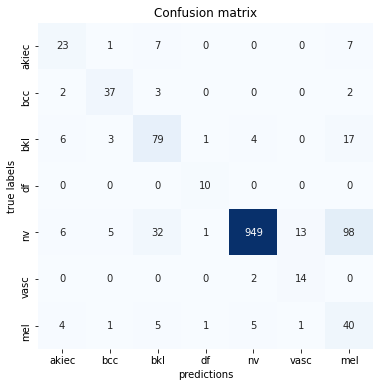

In [41]:
true_labels, predictions = confusion_matrix(net, testloader)
conf_matrix =skmetrics.confusion_matrix(true_labels,predictions)
plt.figure(figsize=(6,6))
plt.title("Confusion matrix")
classes = ['akiec','bcc','bkl','df','nv', "vasc", 'mel']
sns.heatmap(conf_matrix, cmap="Blues", annot = True, xticklabels = classes, yticklabels = classes, fmt = "g", cbar=False)
plt.xlabel("predictions")
plt.ylabel("true labels")

In [42]:
report = classification_report(true_labels, predictions, target_names=classes)
print(report)

              precision    recall  f1-score   support

       akiec       0.56      0.61      0.58        38
         bcc       0.79      0.84      0.81        44
         bkl       0.63      0.72      0.67       110
          df       0.77      1.00      0.87        10
          nv       0.99      0.86      0.92      1104
        vasc       0.50      0.88      0.64        16
         mel       0.24      0.70      0.36        57

    accuracy                           0.84      1379
   macro avg       0.64      0.80      0.69      1379
weighted avg       0.90      0.84      0.86      1379

